In [1]:
# from functools import partial
from pathlib import Path
# from typing import Optional, Tuple
# import cv2
# import fire
import numpy as np
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from PIL import Image
from scipy.sparse.linalg import eigsh
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.decomposition import PCA
# from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm
import extract_utils as utils
from torch.utils.data import Dataset, DataLoader
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from torch import nn
import torchvision

## Extract Features

In [2]:
# images_list="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/lists/images.txt"
# images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/images"
# model_name="dino_vits16"
# batch_size=1
# output_dir="//home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/dino_vits16"
# which_block=-1
# # Output
# utils.make_output_dir(output_dir)
# # Models
# model_name = model_name.lower()
# model, val_transform, patch_size, num_heads = utils.get_model(model_name)    #patch size= 16 number of heads= 6
# # print("patch size=", patch_size, "number of heads=", num_heads)
# # Add hook
# if 'dino' in model_name or 'mocov3' in model_name:
#     feat_out = {}
#     def hook_fn_forward_qkv(module, input, output):
#         # print("feat_out.keys()", feat_out.keys())
#         feat_out["qkv"] = output
#     model._modules["blocks"][which_block]._modules["attn"]._modules["qkv"].register_forward_hook(hook_fn_forward_qkv)
# else:
#     raise ValueError(model_name)
# # Dataset
# filenames = Path(images_list).read_text().splitlines()
# dataset = utils.ImagesDataset(filenames=filenames, images_root=images_root, transform=val_transform)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=8)
# # print(f'Dataset size: {len(dataset)=}')
# # print(f'Dataloader size: {len(dataloader)=}')
# # Prepare
# # accelerator = Accelerator(fp16=True, cpu=False)
# accelerator = Accelerator(cpu=False)
# # model, dataloader = accelerator.prepare(model, dataloader)
# model = model.to(accelerator.device)
# model.num_features
# # print("model.num_features=", model.num_features)
# # model.get_submodule
# # Process
# pbar = list(tqdm(dataloader, desc='Processing'))
# # Process
# # pbar = list(tqdm(dataloader, desc='Processing'))
# # print("feat_out.keys()=", feat_out.keys())
# for i, (images, files, indices) in enumerate(pbar):
#     output_dict = {}
#     # print("images.shape=", images.shape, "files =", files, "indices", indices)
#
#     # Check if file already exists
#     id = Path(files[0]).stem
#     # print("id=", id)
#     output_file = Path(output_dir) / f'{id}.pth'
#     # if output_file.is_file():
#     #     pbar.write(f'Skipping existing file {str(output_file)}')
#     #     continue
#
#     # Reshape image
#     P = patch_size
#     B, C, H, W = images.shape
#     H_patch, W_patch = H // P, W // P
#     H_pad, W_pad = H_patch * P, W_patch * P
#     T = H_patch * W_patch + 1  # number of tokens, add 1 for [CLS]
#     # images = F.interpolate(images, size=(H_pad, W_pad), mode='bilinear')  # resize image
#     images = images[:, :, :H_pad, :W_pad]
#     images = images.to(accelerator.device)
#     # print("images.shape after padding=", images.shape)
#
#     # Forward and collect features into output dict
#     if 'dino' in model_name or 'mocov3' in model_name:
#         # accelerator.unwrap_model(model).get_intermediate_layers(images)[0].squeeze(0)
#         model.get_intermediate_layers(images)[0].squeeze(0)
#         # print(model.get_intermediate_layers(images)[0])
#         # output_dict['out'] = out
#         # print("feat_out.keys()=", feat_out.keys())
#         output_qkv = feat_out["qkv"].reshape(B, T, 3, num_heads, -1 // num_heads).permute(2, 0, 3, 1, 4)
#         # print("type(output_qkv)", type(output_qkv))
#         # print("output_qkv.shape", output_qkv.shape)    #3, 1, 6, 931, 64]
#         # print("output_qkv[0].shape", output_qkv[0].shape)
#         # print("output_qkv[1].shape", output_qkv[1].shape)
#         # print("output_qkv[2].shape", output_qkv[2].shape)
#         # output_dict['q'] = output_qkv[0].transpose(1, 2).reshape(B, T, -1)[:, 1:, :]
#         output_dict['k'] = output_qkv[1].transpose(1, 2).reshape(B, T, -1)[:, 1:, :]
#         # print("output_dict[k].shape=", output_dict['k'].shape)
#         # output_dict['v'] = output_qkv[2].transpose(1, 2).reshape(B, T, -1)[:, 1:, :]
#     else:
#         raise ValueError(model_name)
#
#     # print("output_dict.items=", output_dict.items())
#     # Metadata
#     output_dict['indices'] = indices[0]
#     output_dict['file'] = files[0]
#     output_dict['id'] = id
#     output_dict['model_name'] = model_name
#     output_dict['patch_size'] = patch_size
#     output_dict['shape'] = (B, C, H, W)
#     output_dict = {k: (v.detach().cpu() if torch.is_tensor(v) else v) for k, v in output_dict.items()}
#     # for k, v in output_dict.items():
#     #     print("k=", k)
#     #     if torch.is_tensor(v):
#     #         print("v.shape", v.shape)
#     #     else:
#     #         print("v=", v)
#     # print("output_dict.keys()", output_dict.keys())
#     # print("output_dict['k'].shape=", output_dict['k'].shape,"output_dict['indices'] =", indices[0],"output_dict['file'] =", files[0],"output_dict['id']=" , id, "output_dict['model_name'] =", model_name," output_dict['shape'] =(", B, C, H, W,")output_dict['patch_size'] =",  patch_size )
#     # Save
#     accelerator.save(output_dict, str(output_file))
#     accelerator.wait_for_everyone()
# print(f'Saved features to {output_dir}')

In [3]:
# output_dict = {k: (v.detach().cpu() if torch.is_tensor(v) else v) for k, v in output_dict.items()}
# print(output_dict.keys())
# for k, v in output_dict.items():
#     print("k=", k)
#     print("v.shape=", v.shape)


## Extract Eigen Vectors

In [4]:
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/images"
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features"
output_dir="//home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1residualsimsiam_dot9ds_10_jn"
filename='0125_resized'
which_matrix= 'laplacian'
which_color_matrix= 'knn'
which_features= 'k'
normalize=True
threshold_at_zero=True
lapnorm= True
K= 5
image_downsample_factor = None
image_color_lambda = 0.0
multiprocessing = 0
batch_size=2
epochs=10

## ResNet Residual Block

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels=1, out_channels=1, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(128, out_channels * self.expansion, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        # print("Before squeezing, out shape=", out.shape)
        out =  out.squeeze().to('cuda')
        # print("After squeezing, out shape=", out.shape)

        return out

In [6]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
#         self.bn1 = nn.BatchNorm1d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
#         self.bn2 = nn.BatchNorm1d(out_channels)
#         # shortcut connection
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=bias),
#                 nn.BatchNorm1d(out_channels)
#             )
#
#     def forward(self, x):
#         residual = x
#
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#
#         out = self.conv2(out)
#         out = self.bn2(out)
#
#         out += self.shortcut(residual)
#         out = self.relu(out)
#
#         return out

In [7]:
# class ResNetBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#         super(ResNetBlock, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm1d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm1d(out_channels)
#         self.downsample = downsample
#
#     def forward(self, x):
#         identity = x
#
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#
#         out = self.conv2(out)
#         out = self.bn2(out)
#
#         if self.downsample is not None:
#             identity = self.downsample(x)
#
#         out += identity
#         out = self.relu(out)
#
#         return out

## Incorporating SimSiam

In [8]:
# Define a custom dataset class
class Feature_Dataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __getitem__(self, index):
        return self.features[index]

    def __len__(self):
        return len(self.features)

In [9]:
# print(feats.shape)

In [10]:
class SimSiam(nn.Module):
    def __init__(self):
        super().__init__()
        # self.projection_head = SimSiamProjectionHead(feats.shape[1], 128,feats.shape[1])
        self.projection_head = BasicBlock()
        # self.projection_head = ResidualBlock(feats.shape[1], feats.shape[1])
        self.prediction_head = SimSiamPredictionHead(feats.shape[1], 128, feats.shape[1])

    def forward(self, x):
        z = self.projection_head(x)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

In [11]:
# utils.make_output_dir(output_dir)
# feat_list=[]
# inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
# batch_size=2
# token_feature_size=384
# for inp in tqdm(inputs[:2]):
#     index, features_file = inp
#     print(index, features_file)
#      # Load
#     data_dict = torch.load(features_file, map_location='cpu')
#     # Load affinity matrix
#     # feats_unsqueeze=data_dict[which_features].cuda()
#     feats = data_dict[which_features].squeeze().cuda()
#     print(feats.shape)
#     # print(feats_unsqueeze.shape)
#     feat_dataset = Feature_Dataset(feats)
#     features_dataloader = DataLoader(feat_dataset, batch_size=2, shuffle=True)
#     i=0
#     for x0 in features_dataloader:
#         if i==0:
#         # for (x0), _, _ in features_dataloader:
#             print("before unsqueezing x0.shape=", x0.shape)
#             x0 = x0.unsqueeze(0).to(device)
#             x1=torchvision.transforms.RandomAffine(0)(x0)
#             x0 = x0.squeeze(0).to(device)
#             x0 = torch.tensor(x0).view(batch_size, 1, 1, token_feature_size)
#             print("After squeezing and viewing x0 shape=", x0.shape)
#             # print("x0.shape=", x0.shape)
#             x1 = x1.squeeze(0).to(device)
#             x1 = torch.tensor(x1).view(batch_size, 1, 1,token_feature_size)
#             print("After squeezing and viewing x0 shape=", x1.shape)
#             print("x1 shape=", x1.shape)
#         else:
#             break
#         i+=1


## Input Images

In [12]:
# utils.make_output_dir(output_dir)
# feat_list=[]
# inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
# for inp in tqdm(inputs[123:124]):
#     index, features_file = inp
#     print(index, features_file)
#      # Load
#     data_dict = torch.load(features_file, map_location='cpu')
#     print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
#     # print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
#     image_id = data_dict['file'][:-4]
#     print(image_id)
#     # Load
#     output_file = str(Path(output_dir) / f'{image_id}.pth')
#     if Path(output_file).is_file():
#         print(f'Skipping existing file {str(output_file)}')
#         # break
#         # return  # skip because already generated
#
#     # Load affinity matrix
#     feats = data_dict[which_features].squeeze().cuda()
#     # print("Without normalizing, Features Shape is",feats.shape)
#     if normalize:
#         feats = F.normalize(feats, p=2, dim=-1)
#     # print("After normalization, Features Shape",feats.shape)
#     # print("which_matrix=", which_matrix)
#     # Eigenvectors of affinity matrix
#     if which_matrix == 'affinity_torch':
#         W = feats @ feats.T
#         # W_feat=contrastive_affinity(feats, feats.T)
#         # print("W shape=", W.shape)
#         if threshold_at_zero:
#             W = (W * (W > 0))
#             # print("W shape=", W.shape)
#         eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
#         eigenvalues = eigenvalues.cpu()
#         eigenvectors = eigenvectors.cpu()
#         print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#
#
#     # Eigenvectors of affinity matrix with scipy
#     elif which_matrix == 'affinity_svd':
#         USV = torch.linalg.svd(feats, full_matrices=False)
#         eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
#         eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
#         print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#
#     # Eigenvectors of affinity matrix with scipy
#     elif which_matrix == 'affinity':
#         # print("Without normalizing, Features Shape is",feats.shape)
#         W = (feats @ feats.T)
#         # W_feat=contrastive_affinity(feats, feats.T)
#         # print("W shape=", W.shape)
#         if threshold_at_zero:
#             W = (W * (W > 0))
#         W = W.cpu().numpy()
#         # print("W shape=", W.shape)
#         eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
#         eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
#         print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#
#     # Eigenvectors of matting laplacian matrix
#     elif which_matrix in ['matting_laplacian', 'laplacian']:
#
#         # Get sizes
#         B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
#         if image_downsample_factor is None:
#             image_downsample_factor = P
#         H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor
#
#         # Upscale features to match the resolution
#         if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
#             feats = F.interpolate(
#                 feats.T.reshape(1, -1, H_patch, W_patch),
#                 size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
#             ).reshape(-1, H_pad_lr * W_pad_lr).T
#
#         ### Feature affinities
#         # print("Without normalizing, Features Shape is",feats.shape)
#
#         W_feat_ds = (feats @ feats.T)
#         # feat_list.append(feats)
#         feat_dataset = Feature_Dataset(feats)
#         if feats.shape[0]%2==0:
#             features_dataloader = DataLoader(feat_dataset, batch_size=batch_size, shuffle=True)
#         else:
#             features_dataloader = DataLoader(feat_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
#         model_simsiam = SimSiam()
#         device = "cuda" if torch.cuda.is_available() else "cpu"
#         model_simsiam.to(device)
#         criterion = NegativeCosineSimilarity()
#         optimizer = torch.optim.SGD(model_simsiam.parameters(), lr=0.06)
#         print("Starting Training")
#         for epoch in range(epochs):
#             total_loss = 0
#             for x0 in features_dataloader:
#             # for (x0), _, _ in features_dataloader:
#             #     print("Before Unsqueezing, x0 shape=", x0.shape)
#                 x0 = x0.unsqueeze(0).to(device)
#                 x0 = x0.unsqueeze(1).to(device)
#                 # print("After Unsqueezing x0 shape=", x0.shape)
#                 x1=torchvision.transforms.RandomAffine(0)(x0)
#                 # print("After Unsqueezing x1 shape=", x1.shape)
#                 # x0 = x0.squeeze(0).to(device)
#                 # print("batch_size=",batch_size)
#                 # x0_new = torch.tensor(x0).view(batch_size, 1, 1, 384)
#                 # x0_new = torch.tensor(x0).view(batch_size, 1, 384)
#                 x0_new = x0.view(batch_size, 1, 1, 384)
#                 # print("After viewing x0 shape=", x0_new.shape)
#                 # print("x0.shape=", x0.shape)
#                 # x1 = x1.squeeze(0).to(device)
#                 # x1 = torch.tensor(x1).view(batch_size, 1, 1,384)
#                 x1_new = x1.view(batch_size, 1, 1, 384)
#                 # print("After viewing x1 shape=", x1_new.shape)
#                 z0, p0 = model_simsiam(x0_new)
#                 z1, p1 = model_simsiam(x1_new)
#                 loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
#                 total_loss += loss.detach()
#                 loss.backward()
#                 optimizer.step()
#                 optimizer.zero_grad()
#             avg_loss = total_loss / len(features_dataloader)
#             print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
#         feats=feats.unsqueeze(1).to(device)
#         feats=feats.unsqueeze(2).to(device)
#         print("After Unsqueezing, feature size=", feats.shape)
#         projected_feature=model_simsiam(feats)
#         W_feat_siam=torch.matmul(projected_feature[0], projected_feature[0].t())
#         W_feat=0.9*W_feat_ds + 0.1*W_feat_siam
#         # print("W_feat.shape=", W_feat.shape)
#         # print("W_feat.shape=", W_feat.shape)
#         # W_feat=contrastive_affinity(feats, feats.T)
#         if threshold_at_zero:
#             W_feat = (W_feat * (W_feat > 0))
#         W_feat = W_feat / W_feat.max()  # NOTE: If features are normalized, this naturally does nothing
#         # W_feat = W_feat.cpu().numpy()
#         W_feat = W_feat.detach().cpu().numpy()
#         # print("W_feat shape=",W_feat.shape)
#
#         ### Color affinities
#         # If we are fusing with color affinites, then load the image and compute
#         if image_color_lambda > 0:
#
#             # Load image
#             image_file = str(Path(images_root) / f'{image_id}.jpg')
#             image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
#             image_lr = np.array(image_lr) / 255.
#
#             # Color affinities (of type scipy.sparse.csr_matrix)
#             if which_color_matrix == 'knn':
#                 W_lr = utils.knn_affinity(image_lr / 255)
#             elif which_color_matrix == 'rw':
#                 W_lr = utils.rw_affinity(image_lr / 255)
#
#             # Convert to dense numpy array
#             W_color = np.array(W_lr.todense().astype(np.float32))
#             # print("W_color shape", W_color.shape)
#
#         else:
#
#             # No color affinity
#             W_color = 0
#
#         # Combine
#         W_comb = W_feat + W_color * image_color_lambda  # combination
#         D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
#         # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
#         if lapnorm:
#             try:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
#             except:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
#         else:
#             try:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
#             except:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
#         eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
#     print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#     # Sign ambiguity
#     for k in range(eigenvectors.shape[0]):
#         if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
#             eigenvectors[k] = 0 - eigenvectors[k]
#
#     # Save dict
#     output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
#     torch.save(output_dict, output_file)

In [13]:
# import matplotlib.pyplot as plt
# # numpy_array = W_feat.numpy()
#
# # Downsample the tensor by averaging values in small blocks
# downsampled_array = np.mean(W_feat.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title('Conv2D + Non-Linear')
# plt.savefig('/home/phdcs2/Downloads/' + 'con2d+non-linear_W_feat_125_1024' )
# plt.show()

## Config MAsks

In [14]:
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/arxivs/arxiv_simsiam_ds/srg_projconv2Dsimsiam_ds_10_jn/crf/laplacian_dino_vits16"
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/arxivs/arxiv_simsiam_ds/features_projconv2Dsimsiam_ds_10_jn/"
output_dir="//home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1residualsimsiam_dot9ds_10_jn_plotfeature_new"
utils.make_output_dir(output_dir)
feat_list=[]
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
for inp in tqdm(inputs[123:124]):
    index, features_file = inp
    print(index, features_file)
     # Load
    data_dict = torch.load(features_file, map_location='cpu')
    print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
    # print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
    image_id = data_dict['file'][:-4]
    print(image_id)
    # Load
    output_file = str(Path(output_dir) / f'{image_id}.pth')
    if Path(output_file).is_file():
        print(f'Skipping existing file {str(output_file)}')
        # break
        # return  # skip because already generated

    # Load affinity matrix
    feats = data_dict[which_features].squeeze().cuda()
    # print("Without normalizing, Features Shape is",feats.shape)
    if normalize:
        feats = F.normalize(feats, p=2, dim=-1)
    # print("After normalization, Features Shape",feats.shape)
    # print("which_matrix=", which_matrix)
    # Eigenvectors of affinity matrix
    if which_matrix == 'affinity_torch':
        W = feats @ feats.T
        # W_feat=contrastive_affinity(feats, feats.T)
        # print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
            # print("W shape=", W.shape)
        eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
        eigenvalues = eigenvalues.cpu()
        eigenvectors = eigenvectors.cpu()
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)


    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity_svd':
        USV = torch.linalg.svd(feats, full_matrices=False)
        eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
        eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
        print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity':
        # print("Without normalizing, Features Shape is",feats.shape)
        W = (feats @ feats.T)
        # W_feat=contrastive_affinity(feats, feats.T)
        # print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
        W = W.cpu().numpy()
        # print("W shape=", W.shape)
        eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
        eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of matting laplacian matrix
    elif which_matrix in ['matting_laplacian', 'laplacian']:

        # Get sizes
        B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
        if image_downsample_factor is None:
            image_downsample_factor = P
        H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

        # Upscale features to match the resolution
        if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
            feats = F.interpolate(
                feats.T.reshape(1, -1, H_patch, W_patch),
                size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
            ).reshape(-1, H_pad_lr * W_pad_lr).T

        ### Feature affinities
        # print("Without normalizing, Features Shape is",feats.shape)

        W_feat_ds = (feats @ feats.T)
        # feat_list.append(feats)
        feat_dataset = Feature_Dataset(feats)
        if feats.shape[0]%2==0:
            features_dataloader = DataLoader(feat_dataset, batch_size=batch_size, shuffle=True)
        else:
            features_dataloader = DataLoader(feat_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        model_simsiam = SimSiam()
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model_simsiam.to(device)
        criterion = NegativeCosineSimilarity()
        optimizer = torch.optim.SGD(model_simsiam.parameters(), lr=0.06)
        print("Starting Training")
        for epoch in range(epochs):
            total_loss = 0
            for x0 in features_dataloader:
            # for (x0), _, _ in features_dataloader:
            #     print("Before Unsqueezing, x0 shape=", x0.shape)
                x0 = x0.unsqueeze(0).to(device)
                x0 = x0.unsqueeze(1).to(device)
                # print("After Unsqueezing x0 shape=", x0.shape)
                x1=torchvision.transforms.RandomAffine(0)(x0)
                # print("After Unsqueezing x1 shape=", x1.shape)
                # x0 = x0.squeeze(0).to(device)
                # print("batch_size=",batch_size)
                # x0_new = torch.tensor(x0).view(batch_size, 1, 1, 384)
                # x0_new = torch.tensor(x0).view(batch_size, 1, 384)
                x0_new = x0.view(batch_size, 1, 1, 384)
                # print("After viewing x0 shape=", x0_new.shape)
                # print("x0.shape=", x0.shape)
                # x1 = x1.squeeze(0).to(device)
                # x1 = torch.tensor(x1).view(batch_size, 1, 1,384)
                x1_new = x1.view(batch_size, 1, 1, 384)
                # print("After viewing x1 shape=", x1_new.shape)
                z0, p0 = model_simsiam(x0_new)
                z1, p1 = model_simsiam(x1_new)
                loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
                total_loss += loss.detach()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            avg_loss = total_loss / len(features_dataloader)
            print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
        feats=feats.unsqueeze(1).to(device)
        feats=feats.unsqueeze(2).to(device)
        print("After Unsqueezing, feature size=", feats.shape)
        projected_feature=model_simsiam(feats)
        W_feat_siam=torch.matmul(projected_feature[0], projected_feature[0].t())
        W_feat=0.9*W_feat_ds + 0.1*W_feat_siam
        # print("W_feat.shape=", W_feat.shape)
        # print("W_feat.shape=", W_feat.shape)
        # W_feat=contrastive_affinity(feats, feats.T)
        if threshold_at_zero:
            W_feat = (W_feat * (W_feat > 0))
        W_feat = W_feat / W_feat.max()  # NOTE: If features are normalized, this naturally does nothing
        # W_feat = W_feat.cpu().numpy()
        W_feat = W_feat.detach().cpu().numpy()
        # print("W_feat shape=",W_feat.shape)

        ### Color affinities
        # If we are fusing with color affinites, then load the image and compute
        if image_color_lambda > 0:

            # Load image
            image_file = str(Path(images_root) / f'{image_id}.jpg')
            image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
            image_lr = np.array(image_lr) / 255.

            # Color affinities (of type scipy.sparse.csr_matrix)
            if which_color_matrix == 'knn':
                W_lr = utils.knn_affinity(image_lr / 255)
            elif which_color_matrix == 'rw':
                W_lr = utils.rw_affinity(image_lr / 255)

            # Convert to dense numpy array
            W_color = np.array(W_lr.todense().astype(np.float32))
            # print("W_color shape", W_color.shape)

        else:

            # No color affinity
            W_color = 0

        # Combine
        W_comb = W_feat + W_color * image_color_lambda  # combination
        D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
        # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
        if lapnorm:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
        else:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
        eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
    print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
    # Sign ambiguity
    for k in range(eigenvectors.shape[0]):
        if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
            eigenvectors[k] = 0 - eigenvectors[k]

    # Save dict
    output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
    torch.save(output_dict, output_file)

Output dir: //home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1residualsimsiam_dot9ds_10_jn_plotfeature_new


  0%|          | 0/1 [00:00<?, ?it/s]

123 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/arxivs/arxiv_simsiam_ds/features_projconv2Dsimsiam_ds_10_jn/0125_resized.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0125_resized
Skipping existing file //home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1residualsimsiam_dot9ds_10_jn_plotfeature_new/0125_resized.pth
Starting Training
epoch: 00, loss: -0.71823
epoch: 01, loss: -0.81383
epoch: 02, loss: -0.82427
epoch: 03, loss: -0.83033
epoch: 04, loss: -0.83422
epoch: 05, loss: -0.83860
epoch: 06, loss: -0.84188
epoch: 07, loss: -0.84289
epoch: 08, loss: -0.84048
epoch: 09, loss: -0.83670
After Unsqueezing, feature size= torch.Size([1024, 1, 1, 384])


100%|██████████| 1/1 [00:53<00:00, 53.10s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 1024])


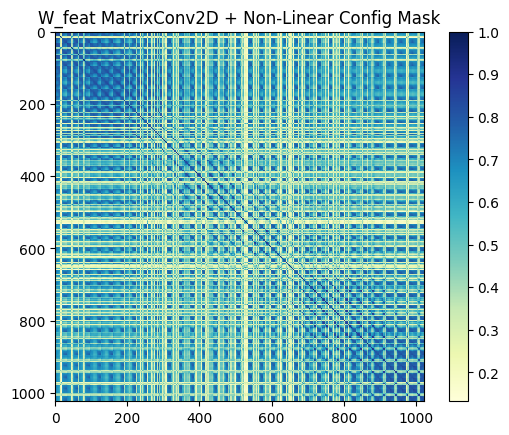

In [15]:
W_feat_configmask=W_feat
W_feat_ds_configmask=W_feat_ds
W_feat_ds_configmask
W_feat_siam_configmask=W_feat_siam
from matplotlib import pyplot as plt
type='Conv2D + Non-Linear Config Mask'
feat='W_feat Matrix'

# Downsample the tensor by averaging values in small blocks
downsampled_array = np.mean(W_feat_configmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_oursmask.reshape(32,32,32,32), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()

# feat='W_ds Matrix'
# # Downsample the tensor by averaging values in small blocks
#
# downsampled_array = np.mean(W_feat_ds_configmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat_ds_oursmask.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title( feat + type)
# plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
# plt.show()

# import matplotlib.pyplot as plt
#
#
# feat='W_Siam Matrix'
# # Downsample the tensor by averaging values in small blocks
#
# downsampled_array = np.mean(W_feat_siam_configmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat_siam_oursmask.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title( feat + type)
# plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
# plt.show()


## Ground Truth Mask

In [16]:
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/ground_truth_mask"
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/mask_features/"
output_dir="//home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1residualsimsiam_dot9ds_10_jn_plotfeature_new"
utils.make_output_dir(output_dir)
feat_list=[]
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
for inp in tqdm(inputs[123:124]):
    index, features_file = inp
    print(index, features_file)
     # Load
    data_dict = torch.load(features_file, map_location='cpu')
    print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
    # print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
    image_id = data_dict['file'][:-4]
    print(image_id)
    # Load
    output_file = str(Path(output_dir) / f'{image_id}.pth')
    if Path(output_file).is_file():
        print(f'Skipping existing file {str(output_file)}')
        # break
        # return  # skip because already generated

    # Load affinity matrix
    feats = data_dict[which_features].squeeze().cuda()
    # print("Without normalizing, Features Shape is",feats.shape)
    if normalize:
        feats = F.normalize(feats, p=2, dim=-1)
    # print("After normalization, Features Shape",feats.shape)
    # print("which_matrix=", which_matrix)
    # Eigenvectors of affinity matrix
    if which_matrix == 'affinity_torch':
        W = feats @ feats.T
        # W_feat=contrastive_affinity(feats, feats.T)
        # print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
            # print("W shape=", W.shape)
        eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
        eigenvalues = eigenvalues.cpu()
        eigenvectors = eigenvectors.cpu()
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)


    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity_svd':
        USV = torch.linalg.svd(feats, full_matrices=False)
        eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
        eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
        print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of affinity matrix with scipy
    elif which_matrix == 'affinity':
        # print("Without normalizing, Features Shape is",feats.shape)
        W = (feats @ feats.T)
        # W_feat=contrastive_affinity(feats, feats.T)
        # print("W shape=", W.shape)
        if threshold_at_zero:
            W = (W * (W > 0))
        W = W.cpu().numpy()
        # print("W shape=", W.shape)
        eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
        eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
        print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

    # Eigenvectors of matting laplacian matrix
    elif which_matrix in ['matting_laplacian', 'laplacian']:

        # Get sizes
        B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
        if image_downsample_factor is None:
            image_downsample_factor = P
        H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

        # Upscale features to match the resolution
        if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
            feats = F.interpolate(
                feats.T.reshape(1, -1, H_patch, W_patch),
                size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
            ).reshape(-1, H_pad_lr * W_pad_lr).T

        ### Feature affinities
        # print("Without normalizing, Features Shape is",feats.shape)

        W_feat_ds = (feats @ feats.T)
        # feat_list.append(feats)
        feat_dataset = Feature_Dataset(feats)
        if feats.shape[0]%2==0:
            features_dataloader = DataLoader(feat_dataset, batch_size=batch_size, shuffle=True)
        else:
            features_dataloader = DataLoader(feat_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        model_simsiam = SimSiam()
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model_simsiam.to(device)
        criterion = NegativeCosineSimilarity()
        optimizer = torch.optim.SGD(model_simsiam.parameters(), lr=0.06)
        print("Starting Training")
        for epoch in range(epochs):
            total_loss = 0
            for x0 in features_dataloader:
            # for (x0), _, _ in features_dataloader:
            #     print("Before Unsqueezing, x0 shape=", x0.shape)
                x0 = x0.unsqueeze(0).to(device)
                x0 = x0.unsqueeze(1).to(device)
                # print("After Unsqueezing x0 shape=", x0.shape)
                x1=torchvision.transforms.RandomAffine(0)(x0)
                # print("After Unsqueezing x1 shape=", x1.shape)
                # x0 = x0.squeeze(0).to(device)
                # print("batch_size=",batch_size)
                # x0_new = torch.tensor(x0).view(batch_size, 1, 1, 384)
                # x0_new = torch.tensor(x0).view(batch_size, 1, 384)
                x0_new = x0.view(batch_size, 1, 1, 384)
                # print("After viewing x0 shape=", x0_new.shape)
                # print("x0.shape=", x0.shape)
                # x1 = x1.squeeze(0).to(device)
                # x1 = torch.tensor(x1).view(batch_size, 1, 1,384)
                x1_new = x1.view(batch_size, 1, 1, 384)
                # print("After viewing x1 shape=", x1_new.shape)
                z0, p0 = model_simsiam(x0_new)
                z1, p1 = model_simsiam(x1_new)
                loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
                total_loss += loss.detach()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            avg_loss = total_loss / len(features_dataloader)
            print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
        feats=feats.unsqueeze(1).to(device)
        feats=feats.unsqueeze(2).to(device)
        print("After Unsqueezing, feature size=", feats.shape)
        projected_feature=model_simsiam(feats)
        W_feat_siam=torch.matmul(projected_feature[0], projected_feature[0].t())
        W_feat=0.9*W_feat_ds + 0.1*W_feat_siam
        # print("W_feat.shape=", W_feat.shape)
        # print("W_feat.shape=", W_feat.shape)
        # W_feat=contrastive_affinity(feats, feats.T)
        if threshold_at_zero:
            W_feat = (W_feat * (W_feat > 0))
        W_feat = W_feat / W_feat.max()  # NOTE: If features are normalized, this naturally does nothing
        # W_feat = W_feat.cpu().numpy()
        W_feat = W_feat.detach().cpu().numpy()
        # print("W_feat shape=",W_feat.shape)

        ### Color affinities
        # If we are fusing with color affinites, then load the image and compute
        if image_color_lambda > 0:

            # Load image
            image_file = str(Path(images_root) / f'{image_id}.jpg')
            image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
            image_lr = np.array(image_lr) / 255.

            # Color affinities (of type scipy.sparse.csr_matrix)
            if which_color_matrix == 'knn':
                W_lr = utils.knn_affinity(image_lr / 255)
            elif which_color_matrix == 'rw':
                W_lr = utils.rw_affinity(image_lr / 255)

            # Convert to dense numpy array
            W_color = np.array(W_lr.todense().astype(np.float32))
            # print("W_color shape", W_color.shape)

        else:

            # No color affinity
            W_color = 0

        # Combine
        W_comb = W_feat + W_color * image_color_lambda  # combination
        D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
        # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
        if lapnorm:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
        else:
            try:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
            except:
                eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
        eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
    print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
    # Sign ambiguity
    for k in range(eigenvectors.shape[0]):
        if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
            eigenvectors[k] = 0 - eigenvectors[k]

    # Save dict
    output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
    torch.save(output_dict, output_file)

Output dir: //home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1residualsimsiam_dot9ds_10_jn_plotfeature_new


  0%|          | 0/1 [00:00<?, ?it/s]

123 /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/mask_features/0125_resized.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0125_resized
Skipping existing file //home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1residualsimsiam_dot9ds_10_jn_plotfeature_new/0125_resized.pth
Starting Training
epoch: 00, loss: -0.73733
epoch: 01, loss: -0.83691
epoch: 02, loss: -0.84997
epoch: 03, loss: -0.85872
epoch: 04, loss: -0.85445
epoch: 05, loss: -0.86186
epoch: 06, loss: -0.86616
epoch: 07, loss: -0.87690
epoch: 08, loss: -0.87393
epoch: 09, loss: -0.88210
After Unsqueezing, feature size= torch.Size([1024, 1, 1, 384])


100%|██████████| 1/1 [00:57<00:00, 57.66s/it]

eigenvalues shape torch.Size([5]) eigenvectors shape torch.Size([5, 1024])


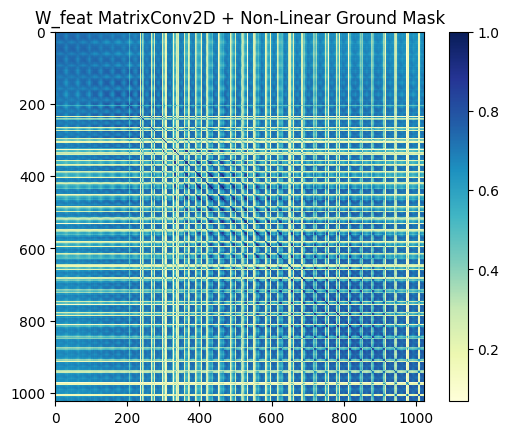

In [17]:
W_feat_groundmask=W_feat
W_feat_ds_groundmask=W_feat_ds
W_feat_siam_groundmask=W_feat_siam
type='Conv2D + Non-Linear Ground Mask'
feat='W_feat Matrix'

# Downsample the tensor by averaging values in small blocks
downsampled_array = np.mean(W_feat_groundmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_oursmask.reshape(32,32,32,32), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()

# feat='W_ds Matrix'
# # Downsample the tensor by averaging values in small blocks
#
# downsampled_array = np.mean(W_feat_ds_groundmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat_ds_oursmask.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title( feat + type)
# plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
# plt.show()
#
# import matplotlib.pyplot as plt
#
#
# feat='W_Siam Matrix'
# # Downsample the tensor by averaging values in small blocks
#
# downsampled_array = np.mean(W_feat_siam_groundmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat_siam_oursmask.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title( feat + type)
# plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
# plt.show()

## Computing Frobenius Norm between Masks

In [18]:
# Calculate element-wise squared difference between the matrices
squared_diff = (W_feat_groundmask - W_feat_configmask) ** 2

# Sum the squared differences
sum_squared_diff = np.sum(squared_diff)

# Take the square root to get the Frobenius norm
frobenius_norm = np.sqrt(sum_squared_diff)

print("Frobenius Norm between ground and ours mask affinity:", frobenius_norm.item())

Frobenius Norm between ground and ours mask affinity: 152.5133819580078
